In [1]:
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from collections import Counter


In [6]:
def calculate_class_weights(labels):
    """
    Calculate class weights for imbalanced datasets.
    Args:
        labels (np.array or list): The class labels in the dataset.
    Returns:
        dict: A dictionary mapping each class to its weight.
    """
    classes = np.unique(labels)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
    return dict(zip(classes, weights))


def apply_smote(X, y):
    """
    Apply SMOTE to rebalance the dataset.
    Args:
        X (array-like): Features.
        y (array-like): Labels.
    Returns:
        tuple: Rebalanced X and y.
    """
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled


def apply_smote_dynamic(X, y):
    """
    Apply SMOTE dynamically adjusting n_neighbors for smallest classes.
    """
    class_counts = Counter(y)
    min_class_size = min(class_counts.values())
    n_neighbors = min(5, min_class_size - 1)  # Adjust neighbors to fit smallest class
    smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled


def preprocess_largest_class(X, y):
    """
    Preprocess the dataset by reducing the size of the largest class based on its
    relative size to the second largest class.
    
    Args:
        X (pd.DataFrame or np.array): Features.
        y (pd.Series or np.array): Labels.
        
    Returns:
        tuple: Reduced X and y.
    """
    # Count class frequencies
    class_counts = Counter(y)
    sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    largest_class, largest_count = sorted_classes[0]
    second_largest_count = sorted_classes[1][1]
    
    # Determine the target size for the largest class
    if largest_count > 2 * second_largest_count:
        target_size = largest_count // 2
    else:
        target_size = second_largest_count
    
    # Split the largest class
    X_largest = X[y == largest_class]
    y_largest = y[y == largest_class]
    
    # Resample the largest class to the target size
    X_largest_reduced, y_largest_reduced = resample(
        X_largest, y_largest, replace=False, n_samples=target_size, random_state=42
    )
    
    # Combine reduced largest class with the rest
    X_rest = X[y != largest_class]
    y_rest = y[y != largest_class]
    X_final = pd.concat([X_rest, X_largest_reduced])
    y_final = pd.concat([y_rest, y_largest_reduced])
    
    return X_final, y_final


def apply_smote_dynamic_with_reduction(X, y):
    """
    Apply preprocessing to reduce the largest class, then apply SMOTE dynamically
    with adjusted `n_neighbors` for smallest classes.
    
    Args:
        X (pd.DataFrame or np.array): Features.
        y (pd.Series or np.array): Labels.
        
    Returns:
        tuple: Resampled X and y.
    """
    # Preprocess largest class
    X, y = preprocess_largest_class(X, y)
    
    # Dynamically determine n_neighbors based on smallest class
    class_counts = Counter(y)
    min_class_size = min(class_counts.values())
    n_neighbors = min(5, min_class_size - 1)  # Adjust neighbors to fit smallest class
    
    # Apply SMOTE
    smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    return X_resampled, y_resampled


def downsample_largest_class(X, y):
    """
    Downsample the largest class to the size of the second largest class.
    
    Args:
        X (pd.DataFrame or np.array): Features.
        y (pd.Series or np.array): Labels.
        
    Returns:
        tuple: Downsampled X and y.
    """
    # Count class frequencies
    class_counts = Counter(y)
    sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    largest_class, largest_count = sorted_classes[0]
    second_largest_count = sorted_classes[1][1]
    
    # Resample the largest class to the size of the second largest
    X_largest = X[y == largest_class]
    y_largest = y[y == largest_class]
    
    X_largest_downsampled, y_largest_downsampled = resample(
        X_largest, y_largest, replace=False, n_samples=second_largest_count, random_state=42
    )
    
    # Combine the downsampled largest class with the rest
    X_rest = X[y != largest_class]
    y_rest = y[y != largest_class]
    X_final = pd.concat([X_rest, X_largest_downsampled])
    y_final = pd.concat([y_rest, y_largest_downsampled])
    
    return X_final, y_final


def apply_smote_after_downsampling(X, y):
    """
    Downsample the largest class to the size of the second largest class,
    then apply SMOTE dynamically based on the smallest class size.
    
    Args:
        X (pd.DataFrame or np.array): Features.
        y (pd.Series or np.array): Labels.
        
    Returns:
        tuple: Resampled X and y.
    """
    # Downsample the largest class
    X, y = downsample_largest_class(X, y)
    
    # Determine n_neighbors dynamically based on the smallest class size
    class_counts = Counter(y)
    min_class_size = min(class_counts.values())
    n_neighbors = min(5, min_class_size - 1)  # Adjust neighbors to fit smallest class
    
    # Apply SMOTE
    smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    return X_resampled, y_resampled


In [3]:
# Load the training dataset (replace with your dataset path)
dataset_path = "kdd_train.csv"  # Example for KDD dataset
data = pd.read_csv(dataset_path)

# Assume the last column is the target
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Print original class distribution
print("Original Class Distribution:")
print(y.value_counts())


Original Class Distribution:
label
normal.             778224
satan.               12714
ipsweep.              9985
portsweep.            8330
nmap.                 1853
back.                 1762
warezclient.           816
teardrop.              783
pod.                   211
guess_passwd.           42
buffer_overflow.        24
land.                   17
warezmaster.            16
imap.                   10
rootkit.                 8
loadmodule.              7
multihop.                6
ftp_write.               6
phf.                     2
perl.                    2
spy.                     2
Name: count, dtype: int64



Resampled Class Distribution:
label
satan.              389112
guess_passwd.       389112
spy.                389112
perl.               389112
ftp_write.          389112
imap.               389112
land.               389112
multihop.           389112
phf.                389112
loadmodule.         389112
warezmaster.        389112
portsweep.          389112
rootkit.            389112
buffer_overflow.    389112
warezclient.        389112
teardrop.           389112
back.               389112
nmap.               389112
ipsweep.            389112
pod.                389112
normal.             389112
Name: count, dtype: int64


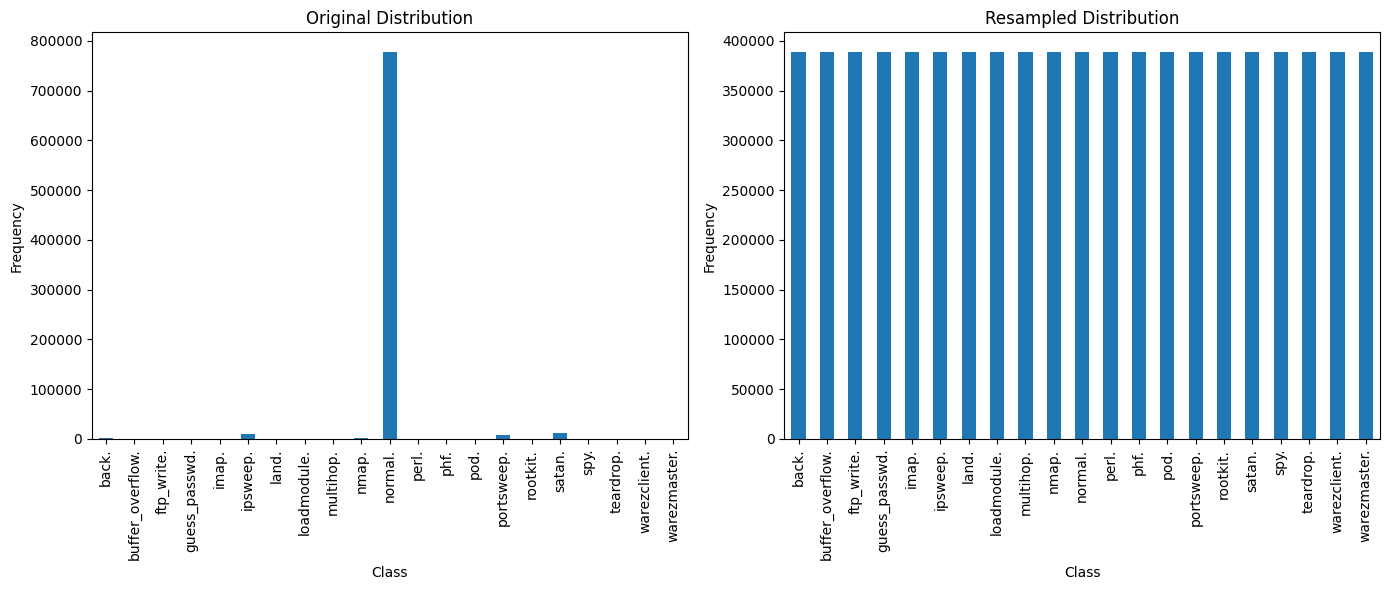


Class Weights (After Resampling):
{'back.': 1.0, 'buffer_overflow.': 1.0, 'ftp_write.': 1.0, 'guess_passwd.': 1.0, 'imap.': 1.0, 'ipsweep.': 1.0, 'land.': 1.0, 'loadmodule.': 1.0, 'multihop.': 1.0, 'nmap.': 1.0, 'normal.': 1.0, 'perl.': 1.0, 'phf.': 1.0, 'pod.': 1.0, 'portsweep.': 1.0, 'rootkit.': 1.0, 'satan.': 1.0, 'spy.': 1.0, 'teardrop.': 1.0, 'warezclient.': 1.0, 'warezmaster.': 1.0}


In [4]:
# Rebalance with SMOTE
X_resampled, y_resampled = apply_smote_dynamic_with_reduction(X, y)

# Print resampled class distribution
print("\nResampled Class Distribution:")
print(pd.Series(y_resampled).value_counts())

# Visualize original and resampled distributions
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
y.value_counts().sort_index().plot(kind='bar', ax=ax[0], title="Original Distribution")
pd.Series(y_resampled).value_counts().sort_index().plot(kind='bar', ax=ax[1], title="Resampled Distribution")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# Optionally calculate class weights
class_weights = calculate_class_weights(y_resampled)
print("\nClass Weights (After Resampling):")
print(class_weights)


In [ ]:
# Load the dataset
dataset_path = "kdd_train.csv"
data = pd.read_csv(dataset_path)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Apply the function
X_resampled, y_resampled = apply_smote_after_downsampling(X, y)

# Print original and resampled class distributions
print("Original Class Distribution:")
print(y.value_counts())

print("\nResampled Class Distribution:")
print(pd.Series(y_resampled).value_counts())


Original Class Distribution:
label
normal.             778224
satan.               12714
ipsweep.              9985
portsweep.            8330
nmap.                 1853
back.                 1762
warezclient.           816
teardrop.              783
pod.                   211
guess_passwd.           42
buffer_overflow.        24
land.                   17
warezmaster.            16
imap.                   10
rootkit.                 8
loadmodule.              7
multihop.                6
ftp_write.               6
phf.                     2
perl.                    2
spy.                     2
Name: count, dtype: int64

Resampled Class Distribution:
label
satan.              12714
guess_passwd.       12714
spy.                12714
perl.               12714
ftp_write.          12714
imap.               12714
land.               12714
multihop.           12714
phf.                12714
loadmodule.         12714
warezmaster.        12714
portsweep.          12714
rootkit.            127